## **Input modelling example: Highway cellular network**

### Problem statement
A telecommunication company has been receiving complaints from its customers regarding the **quality of service** along a 40 km long highway connecting two major cities. The company needs to decide whether or not its system satisfies the required quality in terms of **percentages of dropped and blocked calls**. Some measurements have been made of the traffic in the network on the highway. The company would like to simulate the system to determine whether the system meets the quality of service requirements, and if so, which fixed channel allocation scheme offers the best service.

### Quality of Service Requirements
- Blocked calls < 2%, and
- Dropped calls < 1%

### System Description
The two-way highway is 40 km long. The company uses 20 base stations, each covers a circular area with a diameter of 2 km. There is no overlapping of coverage areas and each base station has a channel capacity of 10 calls, so the number of simultaneous calls is 10 in each coverage area.

When a client initiates a call from within a coverage area, a channel from that base  station will be allocated to the call. If no free channels are available in the base station, the call is **blocked**. When a client making a call crosses a coverage area boundary, the channel being used in the current area is released and a new channel in the new area has to be acquired: this is called a **handover**. If a channel is not available in the new base station during a handover the call is **dropped**. When a subscriber making a call exits the 40-km highway (from either end), the call will be terminated and the channel being used is released.

Using simulation results, the company wants you to test various channel allocation scenarios. The company has provided the following measurements:

- Call initiation times
- Base stations from which the calls are initiated
- Call durations (sec)
- Speed of cars (km/h)

**Assumptions and simplifications**

The traffic volumes in the two directions are the same. This means the two directions of cars travelling along the highway have equal probabilities.
A car maintains the same speed during a call.
The position of the car initiating a call in a cell is uniformly distributed along the section of the highway covered by the base station.

### Input Modelling
Analyze the measured data to find what distributions the inter-arrival times of calls, the locations where calls are generated, the call durations, and car speeds follow respectively. You also need to find the parameter values of these distributions. The measured data are provided in `input.xlsx`.

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import expon, norm
import numpy as np
import pandas as pd
from scipy import stats

In [ ]:
data = pd.read_excel('cellularnetwork.xlsx')
data.head()

,Arrival no,Arrival time (sec),Base station,Call duration (sec),velocity (km/h)
0,1,0.000000,18,76.133611,125.934254
1,2,0.067744,7,159.056244,95.510881
2,3,0.559184,6,179.465053,127.757456
3,4,0.625319,14,163.108320,134.310552
4,5,1.345066,2,95.054472,112.272359


In [ ]:
data.shape

(10000, 5)

#### ***1) Inter-arrival times***

In [ ]:
arrival_time = data['Arrival time (sec)']
interarrival_time = arrival_time.diff().dropna()

In [ ]:
#look at descriptive stats
interarrival_time.describe()

count    9999.000000
mean        1.369817
std         1.343922
min         0.000025
25%         0.407874
50%         0.961708
75%         1.891807
max        12.498550
Name: Arrival time (sec), dtype: float64

In [ ]:
#compare biased / unbiased estimators of std
print('Biased std: %.6f' % interarrival_time.std(ddof=0))
print('Unbiased std: %.6f' % interarrival_time.std(ddof=1))

Biased std: 1.343855
Unbiased std: 1.343922


#### Identify probability distribution
Plot **histogram** and try to fit a **kernel density** (smooth line) to detect any bi-modality or another pattern, and to identify potential distributions.

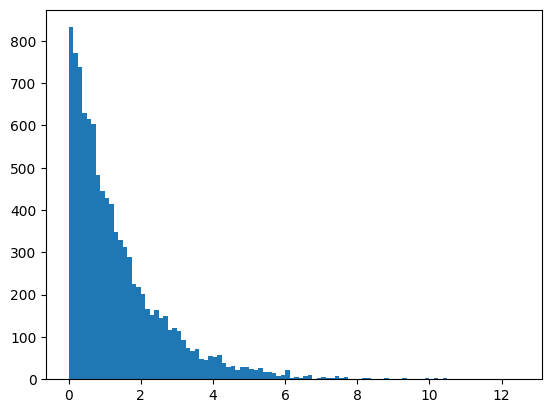

In [ ]:
# draw hist
plt.hist(interarrival_time,100)
plt.show()

<Axes: xlabel='Arrival time (sec)', ylabel='Density'>

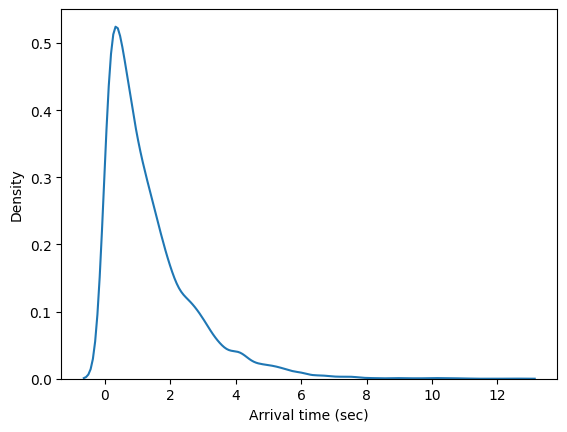

In [ ]:
# fit a kernel
import seaborn as sns
sns.kdeplot(interarrival_time)

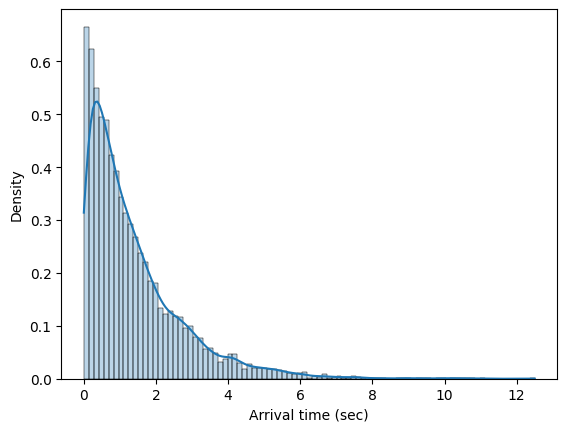

In [ ]:
# draw hist and fit a kernel
import seaborn as sns
sns.histplot(interarrival_time, label='Inter Arrival Time',kde=True,stat="density",alpha=0.3)
plt.show()

Get help from ACF and PACF graphs to reveal any **auto-correlation** structure in your data.

Try Q-Q plots on a number of alternatives to **select a distribution family** (or a number of potential candidates). Always refer to [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats) documentation to get to know what input parameters need to provided for each distribution.

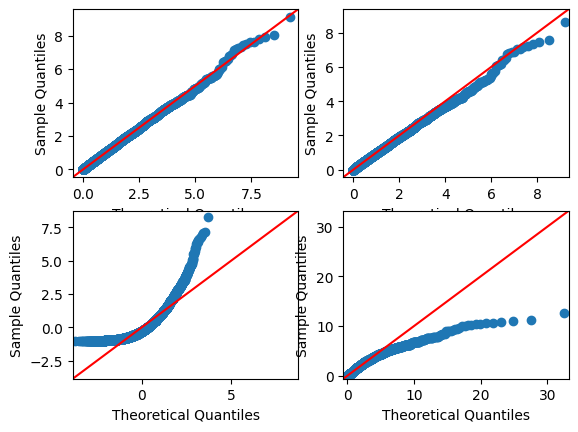

In [ ]:
import statsmodels.api as sm
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
sm.qqplot(interarrival_time, stats.expon, fit=True, line="45", ax=ax)
ax = fig.add_subplot(2, 2, 2)
sm.qqplot(interarrival_time, stats.gamma, fit=True, line="45", ax=ax)
ax = fig.add_subplot(2, 2, 3)
sm.qqplot(interarrival_time, stats.norm, fit=True, line="45", ax=ax)
ax = fig.add_subplot(2, 2, 4)
sm.qqplot(interarrival_time, stats.lognorm, fit=True, line="45", ax=ax)
# stats.probplot(interarrival_time, dist=stats.norm,plot=ax)
plt.show()

There is in fact an **automated way** of searching for an appropriate distribution and estimating its parameters (see `distfit()` below). The most suitable distribution is selected as Beta distribution.

#### Estimate Parameters and Perform Goodness-of-fit
##### K-S test on interarrival times

In [ ]:
from scipy.stats import kstest
# kstest(interarrival_time,'beta',
#        [1.0075580035477385,
#         50.91118687221094,
#         2.395382549338611e-05,
#         70.59205633029417])
kstest(interarrival_time,'expon',
       [0.0000,1.369817])

KstestResult(statistic=0.010023150692294924, pvalue=0.2658106043225813, statistic_location=0.5159609783768246, statistic_sign=-1)

In [ ]:
lambda_mle = 1 / np.mean(interarrival_time)
lambda_mle

0.7300245607069724

#### ***2) Call durations***
*Repeat the same analysis above for call durations.*

In [ ]:
call_duration = data['Call duration (sec)']

### `Distfit` library for fitting distributions

In [ ]:
# %pip install distfit
import numpy as np
from distfit import distfit

# Generate 10000 normal distribution samples with mean 0, std dev of 3
#X = np.random.normal(0, 3, 10000)
#X = norm.rvs(0,3,10000)
X = interarrival_time

# Initialize distfit
dist = distfit()

# Determine best-fitting probability distribution for data
dist.fit_transform(X)

In [ ]:
print(dist.summary)

          name     score              loc       scale  \
0         beta  0.003697         0.000024   70.592056   
1        expon  0.004863         0.000025    1.369792   
2       pareto  0.004863 -33554431.999975  33554432.0   
3        gamma  0.005686         0.000025    1.455615   
4      lognorm  0.093797        -0.111492    0.998083   
5   genextreme  0.167439         0.642732    0.639606   
6            t   0.51999         1.003759    0.811141   
7     dweibull  0.615389         1.102466    0.977789   
8         norm  0.766658         1.369817    1.343855   
9     loggamma   0.78265      -538.281608   69.086739   
10     uniform  2.044559         0.000025   12.498525   

                                        arg  \
0   (1.0075580035477385, 50.91118687221094)   
1                                        ()   
2                     (24496009.135105498,)   
3                     (0.9903569322506334,)   
4                     (0.9365149622809232,)   
5                   (-0.452828849

[distfit] >INFO> Ploting Summary.


(<Figure size 2000x1000 with 1 Axes>,
 <Axes: title={'center': 'Beta (best fit)'}, xlabel='Probability Density Function (PDF)', ylabel='RSS (goodness of fit test)'>)

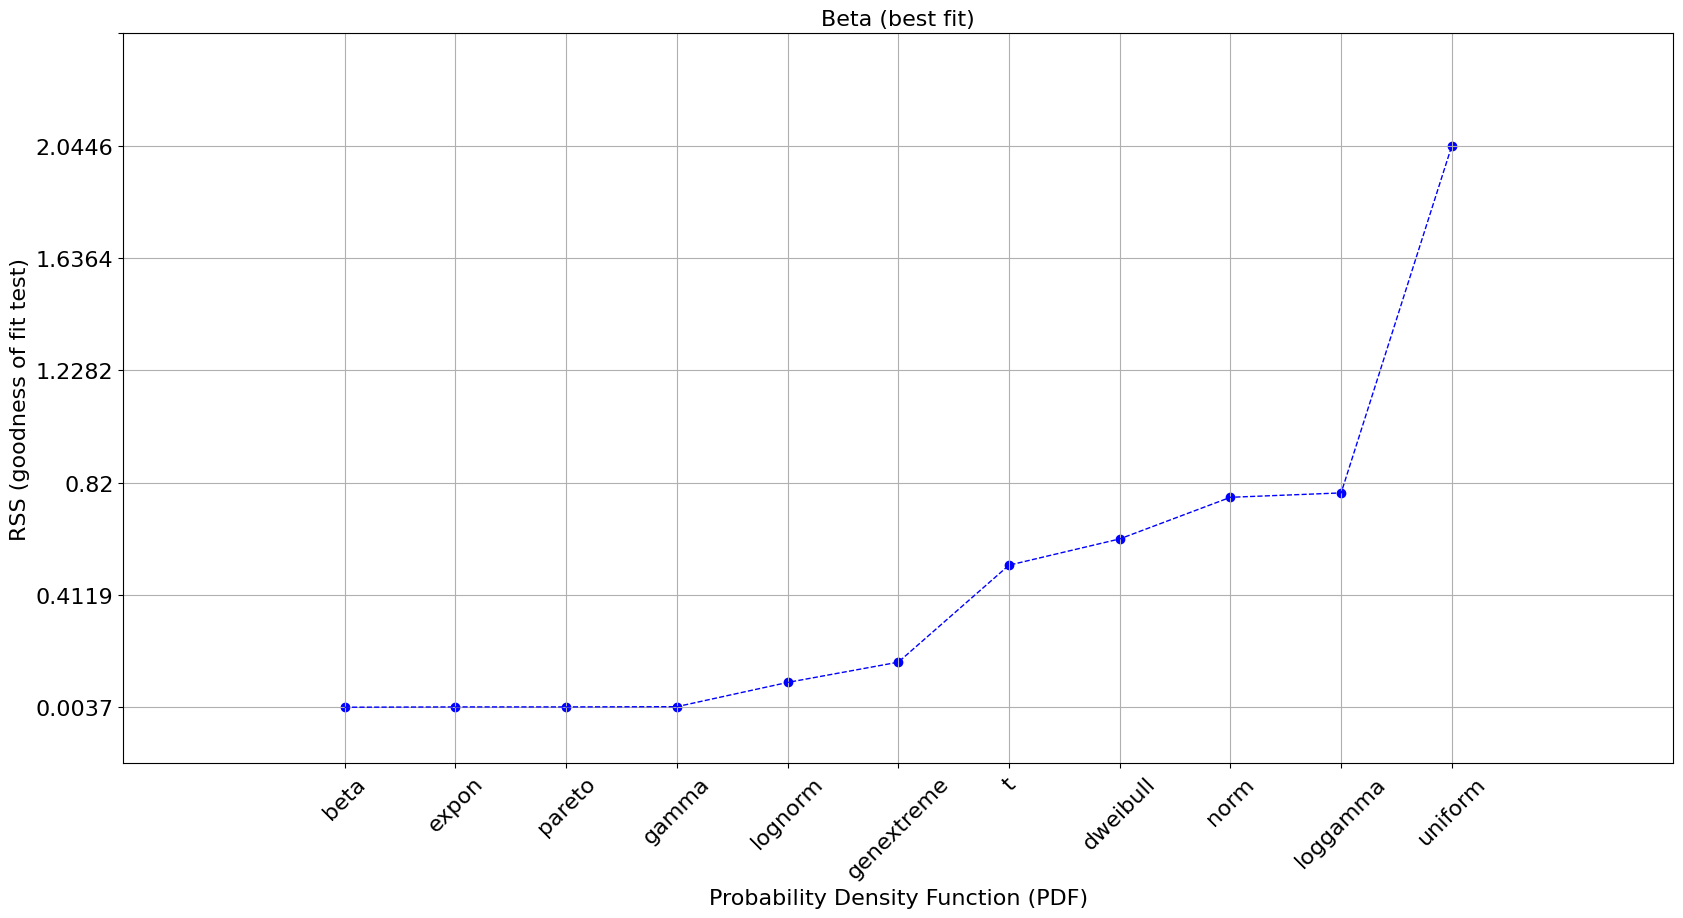

In [ ]:
dist.plot_summary()

[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Beta(loc:0.000024, scale:70.592056)


<Figure size 800x600 with 0 Axes>

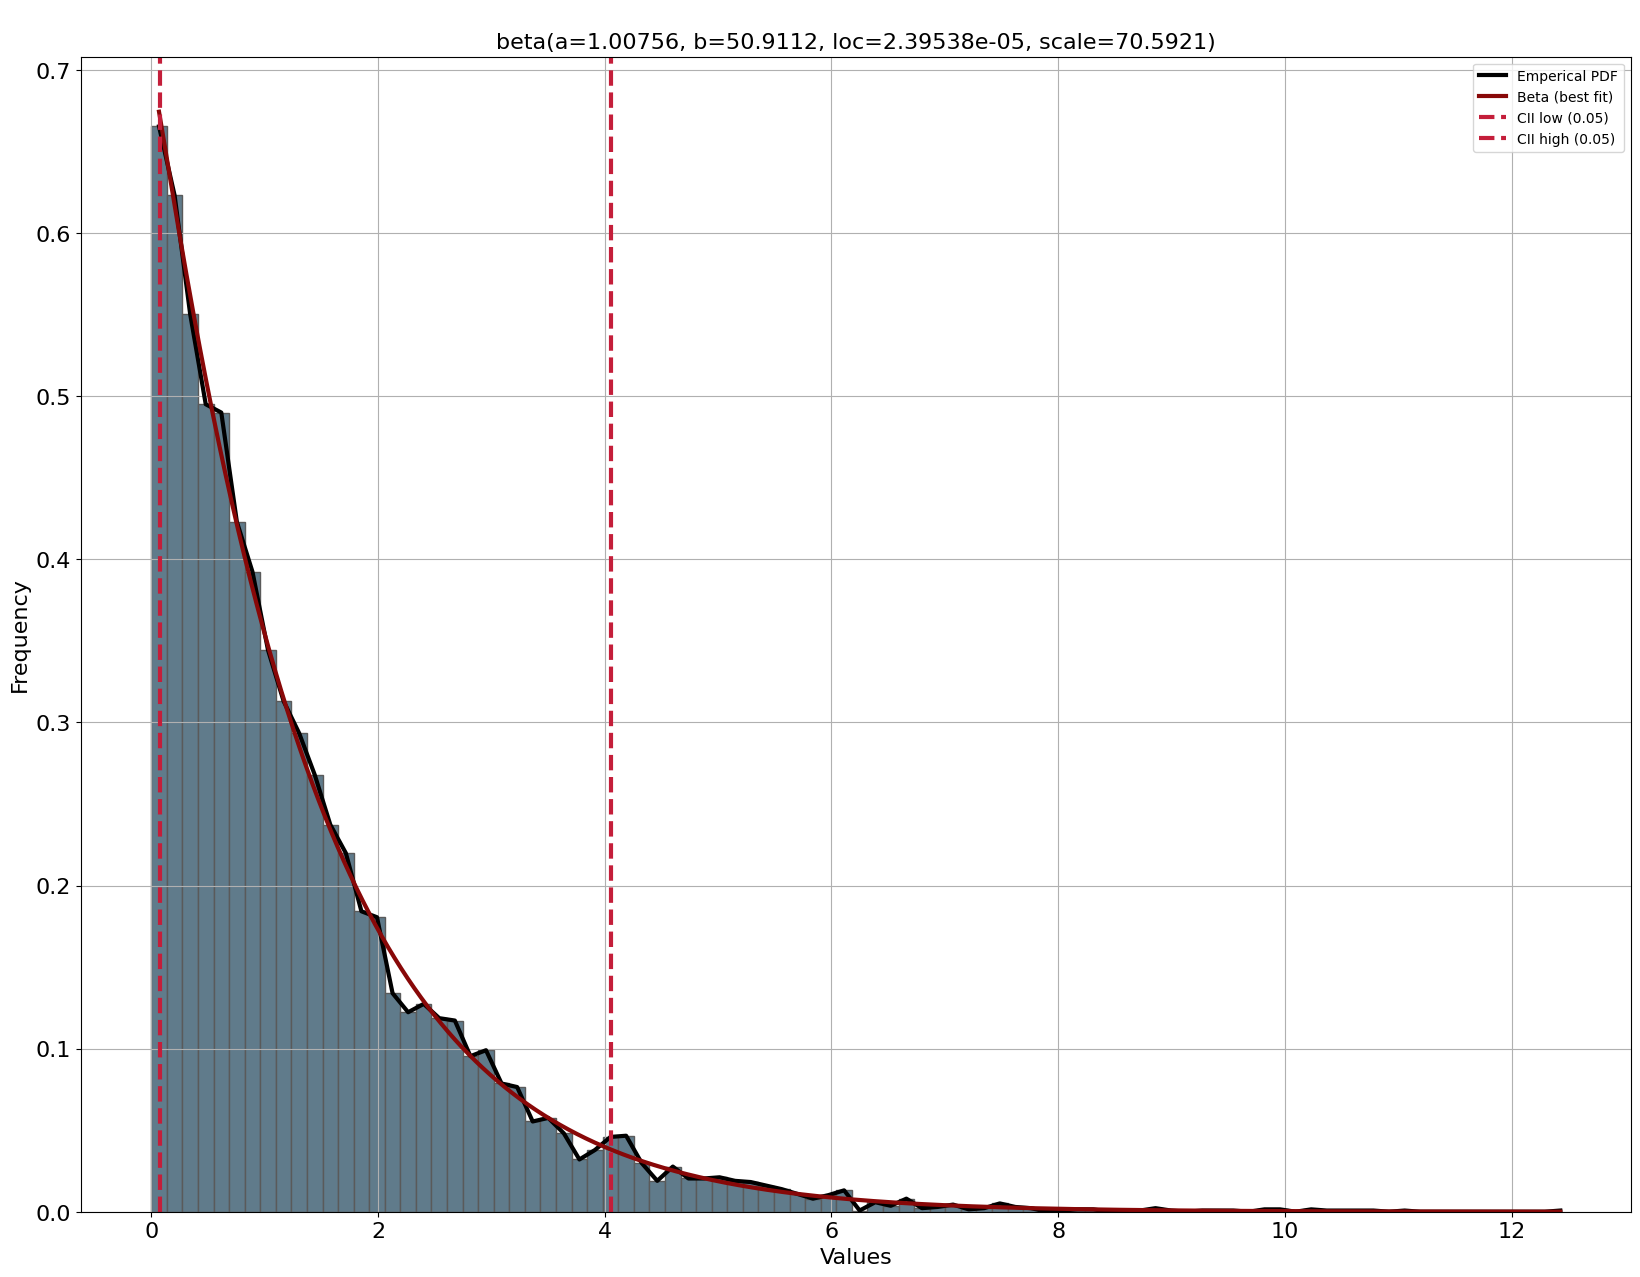

<Figure size 800x600 with 0 Axes>

In [ ]:
dist.plot()

### Resources
- Case adopted from [https://github.com/ritikbhatia](https://github.com/ritikbhatia).
- Best fit: [https://www.kdnuggets.com/2021/09/determine-best-fitting-data-distribution-python.html](https://www.kdnuggets.com/2021/09/determine-best-fitting-data-distribution-python.html)